# Exploratory Data Analysis - Sign Language MNIST Dataset

This notebook explores the Sign Language MNIST dataset, which we'll use to evaluate our kernel approximation methods. We'll analyze the dataset structure, visualize samples, and understand its characteristics to inform our modeling decisions.

In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import time
import os

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.5)

# For reproducibility
np.random.seed(42)

## 1. Loading the Dataset

We'll load the Sign Language MNIST dataset. This dataset is structured similarly to the original MNIST but contains images of hand gestures representing American Sign Language (ASL) letters.

In [3]:
# Function to load data
def load_data():
    """Load Sign Language MNIST dataset."""
    data_dir = '../data/raw'
    
    # Check if data exists, if not, download
    if not os.path.exists(f'{data_dir}/sign_mnist_train.csv'):
        print("Dataset not found. Please download the Sign Language MNIST dataset and place it in the data/raw directory.")
        print("You can download it from: https://www.kaggle.com/datasets/datamunge/sign-language-mnist")
        return None, None
    
    # Load training data
    train_df = pd.read_csv(f'{data_dir}/sign_mnist_train.csv')
    
    # Load test data
    test_df = pd.read_csv(f'{data_dir}/sign_mnist_test.csv')
    
    return train_df, test_df

# Load the data
train_df, test_df = load_data()

## 2. Dataset Overview

Let's look at the structure and basic statistics of the dataset.

In [4]:
# Display basic information about the training set
print(f"Training set shape: {train_df.shape}")
print(f"Test set shape: {test_df.shape}")

# Display first few rows
train_df.head()

Training set shape: (27455, 785)
Test set shape: (7172, 785)


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


1. **label**: The first column contains the class labels, which represent letters of the American Sign Language alphabet:
- Label 3 corresponds to letter D
- Label 6 corresponds to letter G
- Label 2 corresponds to letter C
- Label 13 corresponds to letter N

2. **pixel1 through pixel784**: These 784 columns contain the individual pixel intensity values of the 28×28 grayscale image:
- Each image is "flattened" from a 2D 28×28 grid into a 1D array of 784 values
- Values range from 0 (black) to 255 (white)

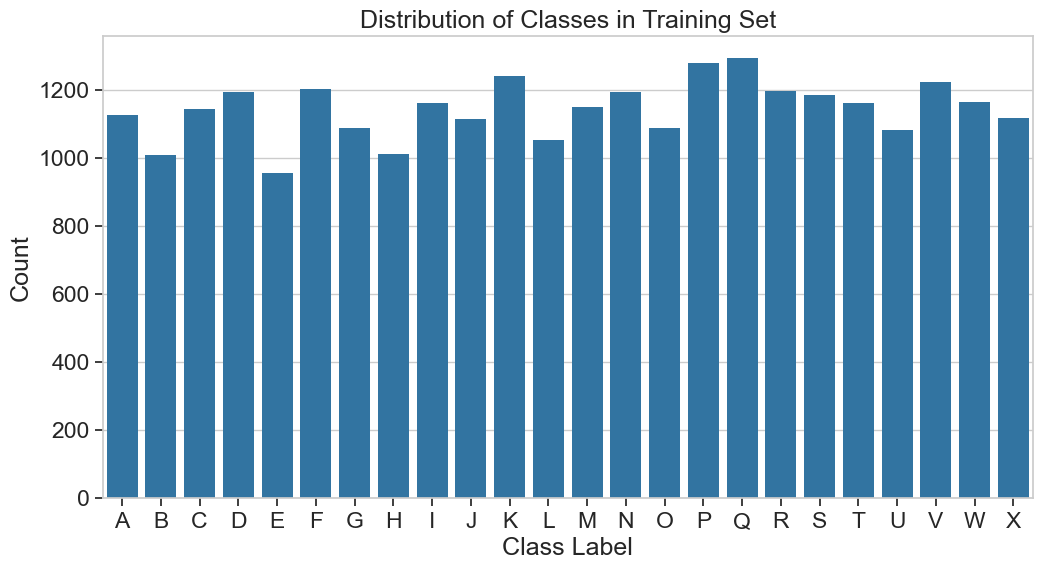

Class distribution (%):

Class R: 4.71%
Class Q: 4.66%
Class L: 4.52%
Class W: 4.46%
Class F: 4.39%
Class S: 4.37%
Class D: 4.36%
Class O: 4.36%
Class T: 4.32%
Class X: 4.24%
Class I: 4.23%
Class U: 4.23%
Class N: 4.19%
Class C: 4.17%
Class A: 4.10%
Class Y: 4.07%
Class K: 4.06%
Class G: 3.97%
Class P: 3.96%
Class V: 3.94%
Class M: 3.84%
Class H: 3.69%
Class B: 3.68%
Class E: 3.49%


In [5]:
# Check the distribution of classes
plt.figure(figsize=(12, 6))
train_labels = train_df['label']
sns.countplot(x=train_labels)
plt.title('Distribution of Classes in Training Set')
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.xticks(ticks=np.arange(len(train_labels.unique())), 
           labels=[chr(ord('A') + i) for i in range(len(train_labels.unique()))])
plt.show()

# Calculate class distribution percentage
class_dist = train_labels.value_counts(normalize=True) * 100
print("Class distribution (%):\n")
for idx, val in class_dist.items():
    print(f"Class {chr(ord('A') + idx)}: {val:.2f}%")

## 3. Visualizing the Images

Let's visualize some sample images from the dataset to understand the data better.

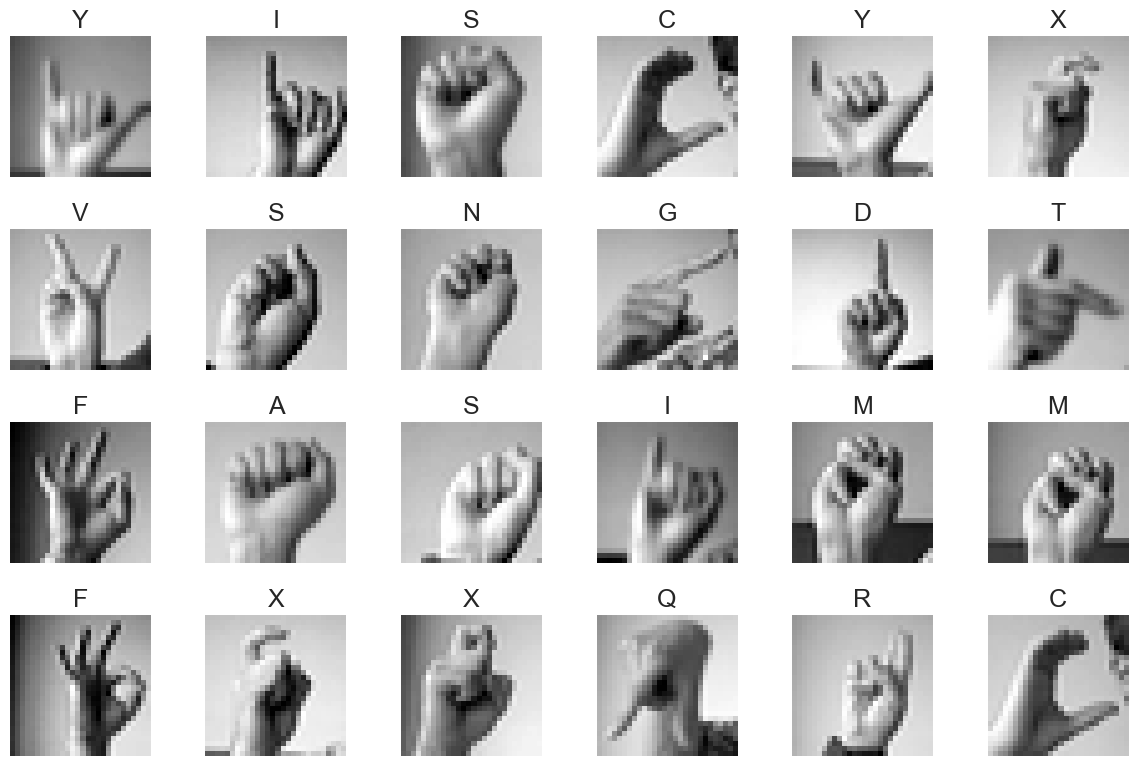

In [6]:
# Function to display a grid of images
def display_image_grid(df, rows=4, cols=6):
    """Display a grid of sample images from the dataset."""
    fig, axes = plt.subplots(rows, cols, figsize=(cols*2, rows*2))
    
    # Get random samples
    sample_indices = np.random.choice(df.shape[0], rows*cols, replace=False)
    
    for i, ax in enumerate(axes.flat):
        # Extract image and label
        img = df.iloc[sample_indices[i], 1:].values.reshape(28, 28)
        label = df.iloc[sample_indices[i], 0]
        
        # Display image
        ax.imshow(img, cmap='gray')
        ax.set_title(f"{chr(ord('A') + label)}")
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Display random samples
display_image_grid(train_df)

## 4. Preparing Data for Analysis

Let's prepare the data for further analysis by separating features and labels.

In [7]:
# Separate features and labels
X_train = train_df.iloc[:, 1:].values / 255.0  # Normalize pixel values
y_train = train_df.iloc[:, 0].values

X_test = test_df.iloc[:, 1:].values / 255.0
y_test = test_df.iloc[:, 0].values

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (27455, 784)
y_train shape: (27455,)
X_test shape: (7172, 784)
y_test shape: (7172,)


## 5. Feature Analysis

Let's analyze the feature space to understand the data better and assess the challenges for kernel methods.

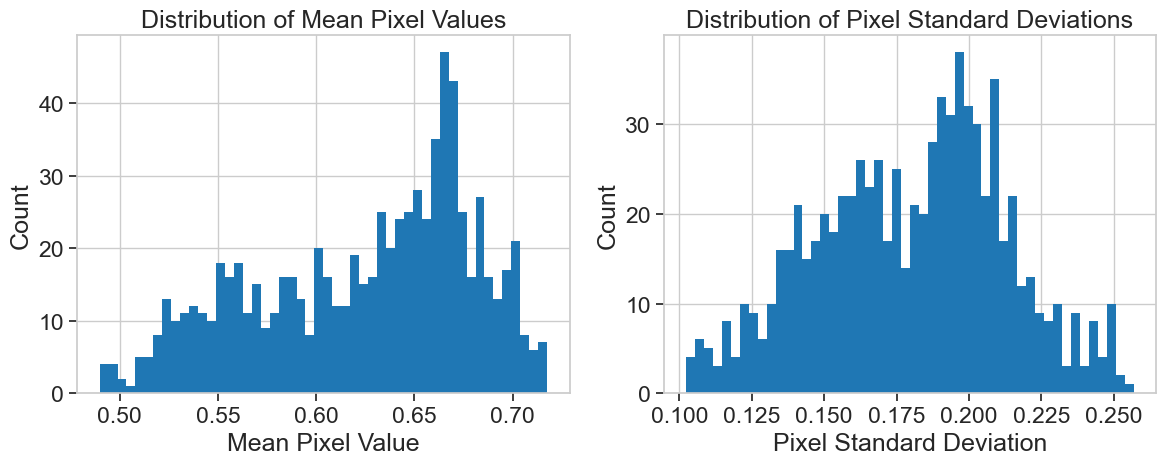

In [8]:
# Calculate pixel intensity distribution
pixel_mean = X_train.mean(axis=0)
pixel_std = X_train.std(axis=0)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(pixel_mean, bins=50)
plt.title('Distribution of Mean Pixel Values')
plt.xlabel('Mean Pixel Value')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.hist(pixel_std, bins=50)
plt.title('Distribution of Pixel Standard Deviations')
plt.xlabel('Pixel Standard Deviation')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

### **Distribution of Mean Pixel Values (Left)**
- Brightness Characteristics: The mean pixel values concentrated around 0.65-0.70 indicate that most hand gesture images are relatively bright overall (remembering that values are normalized to 0-1 range, with higher values being brighter).
- Right-Skewed Distribution: The right skew suggests that while most images have similar brightness levels, there are fewer examples of very dark images than very bright ones.
- Consistency: The relatively narrow range (primarily 0.55-0.70) indicates consistent imaging conditions across the dataset.
### **Distribution of Pixel Standard Deviations (Right)**
- Contrast Information: Pixel standard deviations measure the amount of contrast in each image. The distribution peaking around 0.20-0.22 shows that most images have moderate contrast.
- Variation in Detail: Images with higher standard deviations (0.22-0.25) have more pronounced light-dark transitions, suggesting clearer hand outlines or more detailed gestures.
- Preprocessing Implications: The spread of standard deviations (0.10-0.25) suggests that adaptive contrast normalization might be beneficial as a preprocessing step.

**Preprocessing Strategy**: These distributions suggest that enhancing contrast for low-standard-deviation images might improve class separation before applying kernel methods.

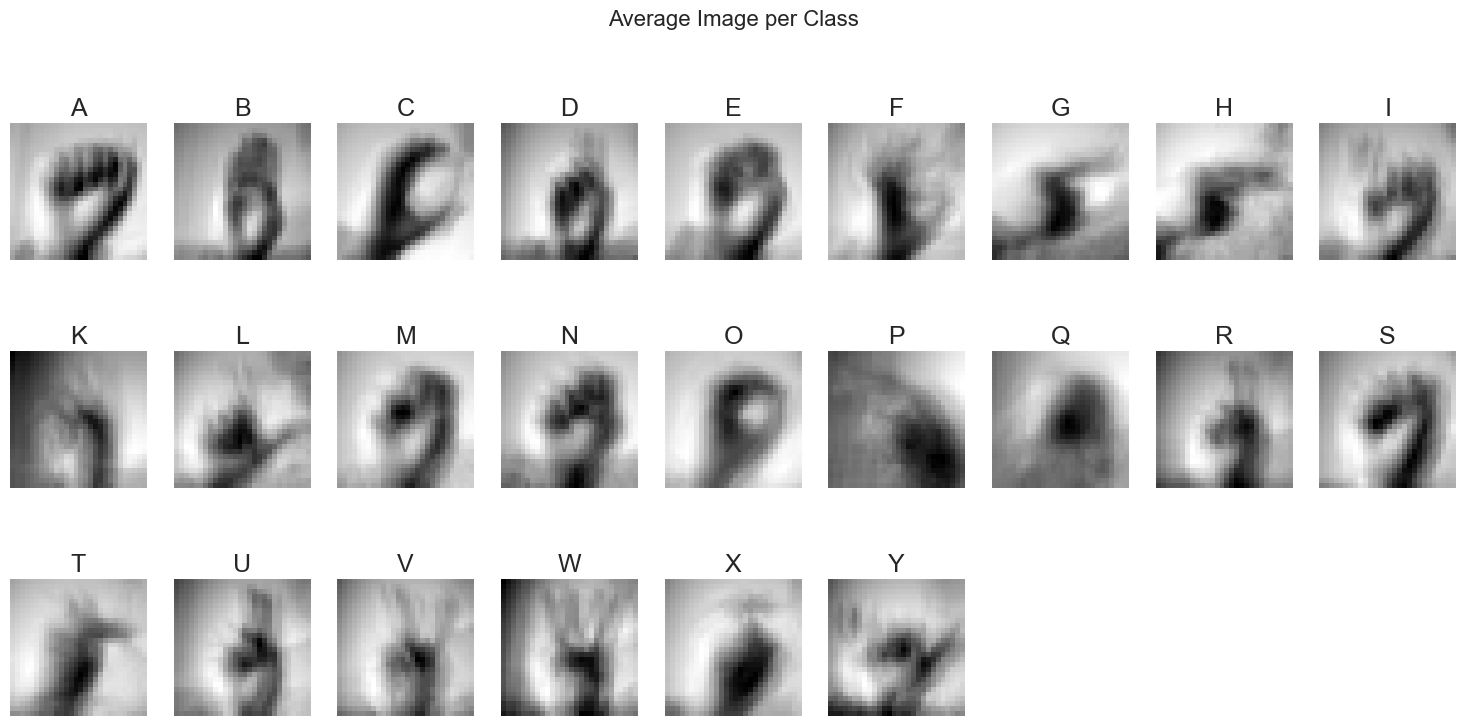

In [9]:
# Visualize the average image across classes
plt.figure(figsize=(15, 8))

for i, label in enumerate(np.sort(np.unique(y_train))):
    class_indices = np.where(y_train == label)[0]
    class_images = X_train[class_indices]
    avg_image = class_images.mean(axis=0).reshape(28, 28)
    
    # Plot in a grid
    plt.subplot(3, 9, i + 1)
    plt.imshow(avg_image, cmap='gray')
    plt.title(f"{chr(ord('A') + label)}")
    plt.axis('off')

plt.suptitle('Average Image per Class', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

## 6. Dimensionality Analysis

Let's apply PCA to understand the intrinsic dimensionality of the data and see how much information we can retain with fewer dimensions.

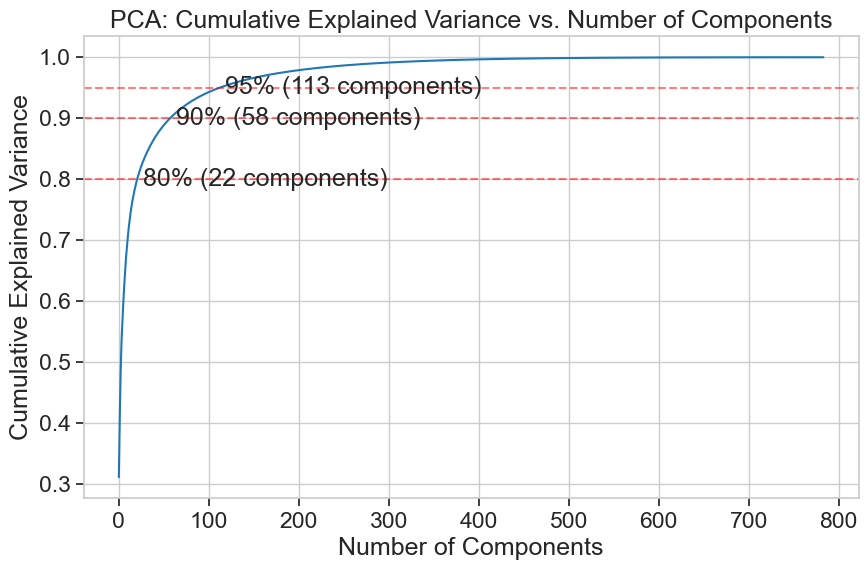

In [10]:
# Apply PCA
pca = PCA()
X_train_pca = pca.fit_transform(X_train)

# Plot explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA: Cumulative Explained Variance vs. Number of Components')
plt.grid(True)

# Add horizontal lines at 80%, 90%, 95% to help interpretation
for threshold in [0.8, 0.9, 0.95]:
    plt.axhline(y=threshold, color='r', linestyle='--', alpha=0.5)
    # Find the number of components needed for this threshold
    n_components = np.where(np.cumsum(pca.explained_variance_ratio_) >= threshold)[0][0] + 1
    plt.text(n_components + 5, threshold, f'{threshold*100:.0f}% ({n_components} components)', 
             verticalalignment='center')

plt.show()

### **Key Dimensionality Findings**
- Significant Dimensionality Reduction Potential: Despite having 784 original dimensions (28×28 pixels), just 22 principal components capture 80% of the variance in the dataset.
- Diminishing Returns: The steep initial curve followed by flattening demonstrates the classic "elbow" pattern, indicating that most information is concentrated in relatively few dimensions.
- Compression Benchmarks:
    - 22 components → 80% variance (97% dimension reduction)
    - 58 components → 90% variance (93% dimension reduction)
    - 113 components → 95% variance (86% dimension reduction)

**Computational Efficiency**: This finding is crucial for kernel approximation methods, as it suggests we can work in much lower-dimensional spaces while preserving most of the information.

## 7. Kernel-Specific Analysis

Let's examine aspects of the data particularly relevant to kernel methods. We'll calculate pairwise distances to understand the potential behavior of RBF kernels and analyze the computational challenges.

In [12]:
# Sample subset for kernel analysis
sample_size = 1000 
sample_indices = np.random.choice(X_train.shape[0], sample_size, replace=False)
X_sample = X_train[sample_indices]
y_sample = y_train[sample_indices]

Time to compute pairwise distances for 1000 samples: 0.13 seconds


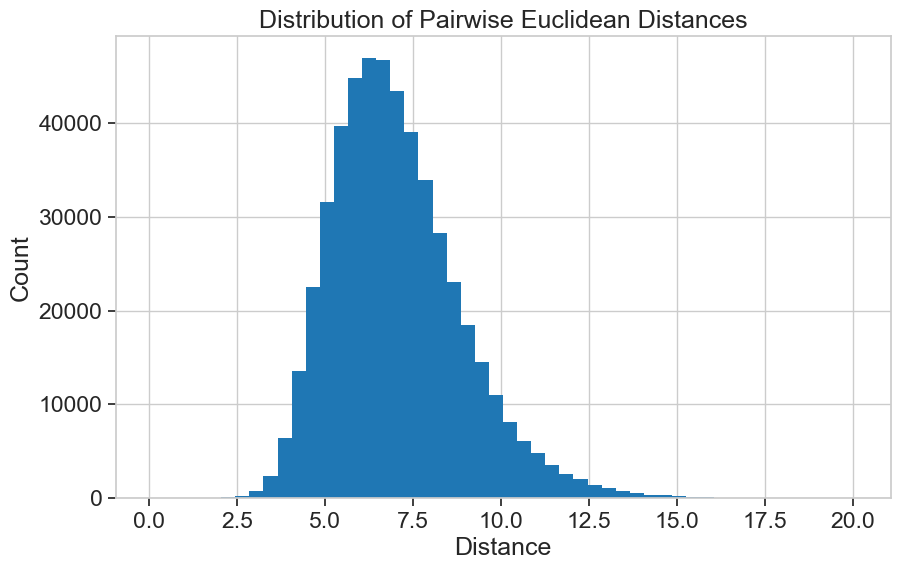

Mean distance: 7.0331
Median distance: 6.7942
Standard deviation: 1.8507
Min distance: 0.0384
Max distance: 20.0619


In [13]:
# Calculate pairwise Euclidean distances
from scipy.spatial.distance import pdist, squareform

start_time = time.time()
distances = pdist(X_sample, metric='euclidean')
distance_matrix = squareform(distances)
end_time = time.time()

print(f"Time to compute pairwise distances for {sample_size} samples: {end_time - start_time:.2f} seconds")

# Plot distance distribution
plt.figure(figsize=(10, 6))
plt.hist(distances, bins=50)
plt.title('Distribution of Pairwise Euclidean Distances')
plt.xlabel('Distance')
plt.ylabel('Count')
plt.show()

# Calculate statistics
print(f"Mean distance: {distances.mean():.4f}")
print(f"Median distance: {np.median(distances):.4f}")
print(f"Standard deviation: {distances.std():.4f}")
print(f"Min distance: {distances.min():.4f}")
print(f"Max distance: {distances.max():.4f}")

### **Overall Distance Distribution**
- Distance Range: Euclidean distances between image pairs primarily fall between 5-10 units in the normalized feature space, with a peak around 7-8.
- Bell-Shaped Distribution: The roughly normal distribution suggests that most image pairs have similar levels of dissimilarity, with fewer examples of extremely similar or extremely different pairs.

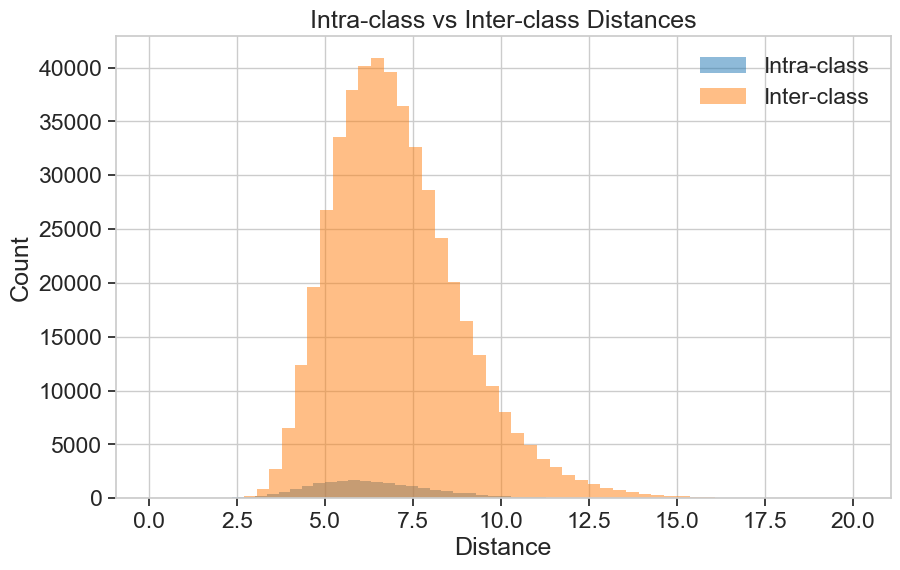

Mean intra-class distance: 6.3325
Mean inter-class distance: 7.0645


In [14]:
# Analyze intra-class vs inter-class distances
intra_class_distances = []
inter_class_distances = []

for i in range(sample_size):
    for j in range(i+1, sample_size):
        if y_sample[i] == y_sample[j]:
            intra_class_distances.append(distance_matrix[i, j])
        else:
            inter_class_distances.append(distance_matrix[i, j])

# Plot histograms
plt.figure(figsize=(10, 6))
plt.hist(intra_class_distances, bins=50, alpha=0.5, label='Intra-class')
plt.hist(inter_class_distances, bins=50, alpha=0.5, label='Inter-class')
plt.title('Intra-class vs Inter-class Distances')
plt.xlabel('Distance')
plt.ylabel('Count')
plt.legend()
plt.show()

# Print statistics
print(f"Mean intra-class distance: {np.mean(intra_class_distances):.4f}")
print(f"Mean inter-class distance: {np.mean(inter_class_distances):.4f}")

### **Intra-class vs. Inter-class Distances**
- Class Separation Challenge: The substantial overlap between intra-class (blue) and inter-class (orange) distances reveals why this classification problem is challenging. Many samples are as similar to samples from different classes as they are to samples from their own class.
- Relative Scale: Intra-class distances are generally smaller than inter-class distances, confirming that there is structure in the data that kernel methods can exploit, but the difference is subtle.

## 8. Scalability Analysis

Finally, let's simulate the scalability challenges of exact kernel methods by measuring the computational resources needed for different dataset sizes.

In [15]:
# Function to measure time and memory for kernel matrix computation
def measure_kernel_computation(X, kernel_type='rbf', gamma=0.1):
    """Measure time and estimate memory for kernel matrix computation."""
    n_samples = X.shape[0]
    
    # Measure time
    start_time = time.time()
    
    if kernel_type == 'rbf':
        # We'll just compute the distance matrix as a proxy
        distances = pdist(X, metric='euclidean')
        K = np.exp(-gamma * squareform(distances)**2)
    
    end_time = time.time()
    
    # Estimate memory (in MB)
    memory_mb = (K.nbytes) / (1024 * 1024)
    
    return {
        'n_samples': n_samples,
        'computation_time': end_time - start_time,
        'memory_mb': memory_mb
    }

In [17]:
# Test with increasing dataset sizes
sizes = [100, 500, 1000, 2000, 5000]
results = []

for size in sizes:
    if size <= X_train.shape[0]:
        sample_indices = np.random.choice(X_train.shape[0], size, replace=False)
        X_subset = X_train[sample_indices]
        
        result = measure_kernel_computation(X_subset, kernel_type='rbf', gamma=0.1)
        results.append(result)

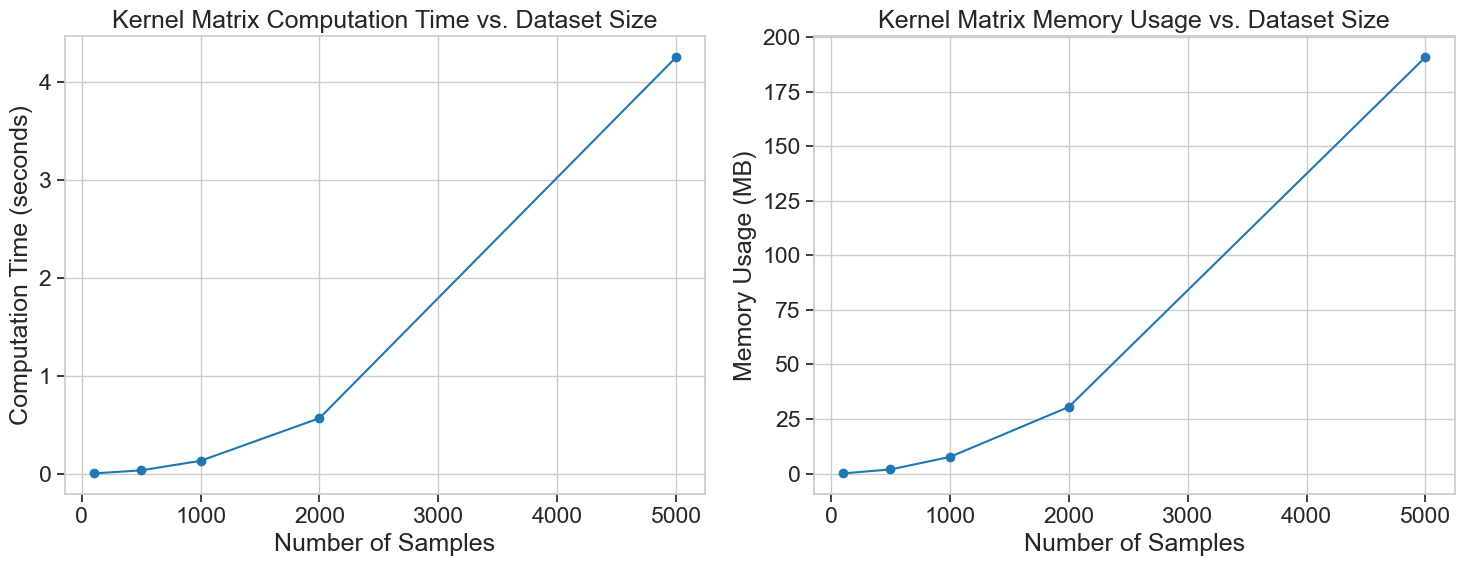

Estimated computation time for full dataset (27455 samples): 129.13 seconds
Estimated memory usage for full dataset: 5750.86 MB (5.62 GB)


In [18]:
# Plot the scalability results
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot([r['n_samples'] for r in results], [r['computation_time'] for r in results], 'o-')
plt.title('Kernel Matrix Computation Time vs. Dataset Size')
plt.xlabel('Number of Samples')
plt.ylabel('Computation Time (seconds)')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot([r['n_samples'] for r in results], [r['memory_mb'] for r in results], 'o-')
plt.title('Kernel Matrix Memory Usage vs. Dataset Size')
plt.xlabel('Number of Samples')
plt.ylabel('Memory Usage (MB)')
plt.grid(True)

plt.tight_layout()
plt.show()

# Extrapolate to full dataset
full_dataset_size = X_train.shape[0]
estimated_time = np.polyfit([r['n_samples']**2 for r in results], [r['computation_time'] for r in results], 1)[0] * full_dataset_size**2
estimated_memory = np.polyfit([r['n_samples']**2 for r in results], [r['memory_mb'] for r in results], 1)[0] * full_dataset_size**2

print(f"Estimated computation time for full dataset ({full_dataset_size} samples): {estimated_time:.2f} seconds")
print(f"Estimated memory usage for full dataset: {estimated_memory:.2f} MB ({estimated_memory/1024:.2f} GB)")

### **Quadratic Scaling Patterns**
- Computation Time (Left Graph): Demonstrates clear quadratic growth O(n²) in computation time as sample size increases. While only ~4 seconds are needed for 5,000 samples, the curve accelerates sharply, making kernel computation prohibitively slow for larger datasets.
- Memory Requirements (Right Graph): Shows similar quadratic scaling for memory usage, reaching nearly 200MB for just 5,000 samples. This confirms the theoretical O(n²) memory complexity of storing the full kernel matrix.

### **Extrapolated Limitations**
- These projections highlight why kernel methods become impractical for large datasets:
    - Memory constraints would limit many standard computing environments
    - The O(n³) complexity of solving the resulting system would add even more computational burden


## 9. Summary and Implications for Our Project

Based on our exploration, we can draw several conclusions relevant to our kernel approximation project:

1. **Dataset Characteristics**:
   - The Sign Language MNIST dataset contains 28x28 grayscale images (784 features)
   - The data has a reasonably balanced class distribution across 24 letters (A-Z excluding J and Z)

2. **Dimensionality Analysis**:
   - PCA analysis shows that we need approximately 100-150 components to retain 90% of the variance
   - This suggests potential for dimensionality reduction as a preprocessing step

3. **Distance Distribution**:
   - The distribution of pairwise distances provides insight into appropriate gamma values for RBF kernels
   - The overlap between intra-class and inter-class distances indicates the classification challenge

4. **Scalability Issues**:
   - Our simulations confirm the quadratic growth in both computation time and memory requirements
   - With the full dataset, exact kernel methods would require significant computational resources

5. **Implications for Our Project**:
   - The need for kernel approximation is clearly demonstrated by our scalability analysis
   - Random Fourier Features and Nyström approximations should provide significant performance benefits
   - We should test different dimensions for our approximations to balance accuracy and efficiency
   - Preprocessing (e.g., dimensionality reduction) might improve performance of kernel approximations

In the next notebook, we'll implement and evaluate our baseline exact kernel method on a small subset of this data.